In [13]:
print('ciao')

ciao


In [14]:
#TUTORIAL: https://pyro.ai/examples/prodlda.html
import math
import torch
import torch.nn as nn #pip install torch torchvision torchaudio
import torch.nn.functional as F
import pyro #pip3 install pyro-ppl 
from pyro.infer import SVI, TraceMeanField_ELBO,  MCMC, NUTS 
import pyro.distributions as dist
from tqdm import trange
import os
from sklearn.datasets import fetch_20newsgroups #pip install scikit-learn
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
# Enable smoke test - run the notebook cells on CI.
smoke_test = 'CI' in os.environ

In [15]:
#Class to execute prodLDAModel
class Encoder(nn.Module):
    # Base class for the encoder net, used in the guide
    def __init__(self, vocab_size, num_topics, hidden, dropout):
        super().__init__()
        self.drop = nn.Dropout(dropout)  # to avoid component collapse
        self.fc1 = nn.Linear(vocab_size, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fcmu = nn.Linear(hidden, num_topics)
        self.fclv = nn.Linear(hidden, num_topics)
        # NB: here we set `affine=False` to reduce the number of learning parameters
        # See https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html
        # for the effect of this flag in BatchNorm1d
        self.bnmu = nn.BatchNorm1d(num_topics, affine=False)  # to avoid component collapse
        self.bnlv = nn.BatchNorm1d(num_topics, affine=False)  # to avoid component collapse

    def forward(self, inputs):
        h = F.softplus(self.fc1(inputs))
        h = F.softplus(self.fc2(h))
        h = self.drop(h)
        # μ and Σ are the outputs
        logtheta_loc = self.bnmu(self.fcmu(h))
        logtheta_logvar = self.bnlv(self.fclv(h))
        logtheta_scale = (0.5 * logtheta_logvar).exp()  # Enforces positivity
        return logtheta_loc, logtheta_scale


class Decoder(nn.Module):
    # Base class for the decoder net, used in the model
    def __init__(self, vocab_size, num_topics, dropout):
        super().__init__()
        self.beta = nn.Linear(num_topics, vocab_size, bias=False)
        self.bn = nn.BatchNorm1d(vocab_size, affine=False)
        self.drop = nn.Dropout(dropout)

    def forward(self, inputs):
        inputs = self.drop(inputs)
        # the output is σ(βθ)
        return F.softmax(self.bn(self.beta(inputs)), dim=1)


class ProdLDA(nn.Module):
    def __init__(self, vocab_size, num_topics, hidden, dropout):
        super().__init__()
        self.vocab_size = vocab_size
        self.num_topics = num_topics
        self.encoder = Encoder(vocab_size, num_topics, hidden, dropout)
        self.decoder = Decoder(vocab_size, num_topics, dropout)

    def model(self, docs):
        pyro.module("decoder", self.decoder)
        with pyro.plate("documents", docs.shape[0]):
            # Dirichlet prior 𝑝(𝜃|𝛼) is replaced by a logistic-normal distribution
            logtheta_loc = docs.new_zeros((docs.shape[0], self.num_topics))
            logtheta_scale = docs.new_ones((docs.shape[0], self.num_topics))
            logtheta = pyro.sample(
                "logtheta", dist.Normal(logtheta_loc, logtheta_scale).to_event(1))
            theta = F.softmax(logtheta, -1)

            # conditional distribution of 𝑤𝑛 is defined as
            # 𝑤𝑛|𝛽,𝜃 ~ Categorical(𝜎(𝛽𝜃))
            count_param = self.decoder(theta)
            # Currently, PyTorch Multinomial requires `total_count` to be homogeneous.
            # Because the numbers of words across documents can vary,
            # we will use the maximum count accross documents here.
            # This does not affect the result because Multinomial.log_prob does
            # not require `total_count` to evaluate the log probability.
            total_count = int(docs.sum(-1).max())
            pyro.sample(
                'obs',
                dist.Multinomial(total_count, count_param),
                obs=docs
            )

    def guide(self, docs):
        pyro.module("encoder", self.encoder)
        with pyro.plate("documents", docs.shape[0]):
            # Dirichlet prior 𝑝(𝜃|𝛼) is replaced by a logistic-normal distribution,
            # where μ and Σ are the encoder network outputs
            logtheta_loc, logtheta_scale = self.encoder(docs)
            logtheta = pyro.sample(
                "logtheta", dist.Normal(logtheta_loc, logtheta_scale).to_event(1))

    def beta(self):
        # beta matrix elements are the weights of the FC layer on the decoder
        return self.decoder.beta.weight.cpu().detach().T

In [16]:
#Prepare dataset to be used in the model
source = './doc/cleaned.csv'
df = pd.read_csv(source)

# Split the text data into words based on spaces
tweets = df['lemmatized_text'].apply(lambda text: text.split())

# Create a CountVectorizer 
# max_df is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
# min_df is used for removing terms that appear too infrequently, at least in 20 documents
vectorizer = CountVectorizer(max_df=0.5, min_df=20)

# Convert the tokenized text data into a document-term matrix
docs = torch.from_numpy(vectorizer.fit_transform([" ".join(tweet) for tweet in tweets]).toarray())


In [17]:
#Show the initial data
vocab = pd.DataFrame(columns=['word', 'index'])
vocab['word'] = vectorizer.get_feature_names_out()
vocab['index'] = vocab.index
print('Dictionary size: %d' % len(vocab)) #vocab_size
print('Corpus size: {}'.format(docs.shape)) # (num_docs, vocab_size)

Dictionary size: 5590
Corpus size: torch.Size([70000, 5590])


In [18]:
'''news = fetch_20newsgroups(subset='all')
vectorizer = CountVectorizer(max_df=0.5, min_df=20, stop_words='english')
docs = torch.from_numpy(vectorizer.fit_transform(news['data']).toarray())
print(news['data'][0:2])

vocab = pd.DataFrame(columns=['word', 'index'])
vocab['word'] = vectorizer.get_feature_names_out()
vocab['index'] = vocab.index
print('Dictionary size: %d' % len(vocab))
print('Corpus size: {}'.format(docs.shape))'''

"news = fetch_20newsgroups(subset='all')\nvectorizer = CountVectorizer(max_df=0.5, min_df=20, stop_words='english')\ndocs = torch.from_numpy(vectorizer.fit_transform(news['data']).toarray())\nprint(news['data'][0:2])\n\nvocab = pd.DataFrame(columns=['word', 'index'])\nvocab['word'] = vectorizer.get_feature_names_out()\nvocab['index'] = vocab.index\nprint('Dictionary size: %d' % len(vocab))\nprint('Corpus size: {}'.format(docs.shape))"

In [19]:
# setting global variables
seed = 0
torch.manual_seed(seed)
pyro.set_rng_seed(seed)
device = torch.device("cpu")

# Now, use the 'device' when creating tensors or performing operations
tensor_on_cpu = torch.tensor([1, 2, 3], device=device)
result = tensor_on_cpu + tensor_on_cpu  # Example operation on CPU


In [20]:
docs = docs.float().to(device)

In [21]:
# setting hyperparameters
num_topics = 8

batch_size = 32
learning_rate = 1e-3
num_epochs = 1

# training
pyro.clear_param_store()

prodLDA = ProdLDA(
    vocab_size=docs.shape[1],
    num_topics=num_topics,
    hidden=100 if not smoke_test else 10,
    dropout=0.2
)
prodLDA.to(device)

optimizer = pyro.optim.Adam({"lr": learning_rate})
svi = SVI(prodLDA.model, prodLDA.guide, optimizer, loss=TraceMeanField_ELBO())
num_batches = int(math.ceil(docs.shape[0] / batch_size)) if not smoke_test else 1

bar = trange(num_epochs)
for epoch in bar:
    running_loss = 0.0
    for i in range(num_batches):
        batch_docs = docs[i * batch_size:(i + 1) * batch_size, :]
        loss = svi.step(batch_docs)
        running_loss += loss / batch_docs.size(0)

    bar.set_postfix(epoch_loss='{:.2e}'.format(running_loss))

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [01:21<00:00, 81.22s/it, epoch_loss=2.21e+05]


In [22]:
torch.save(prodLDA.state_dict(), "models/prodLDA_model.pth")
# Load the model's state_dict
prodLDA1 = ProdLDA(
    vocab_size=docs.shape[1],
    num_topics=num_topics,  # You might need to adjust this based on your needs
    hidden=100 if not smoke_test else 10,
    dropout=0.2
)
prodLDA1.load_state_dict(torch.load("models/prodLDA_model.pth"))

<All keys matched successfully>

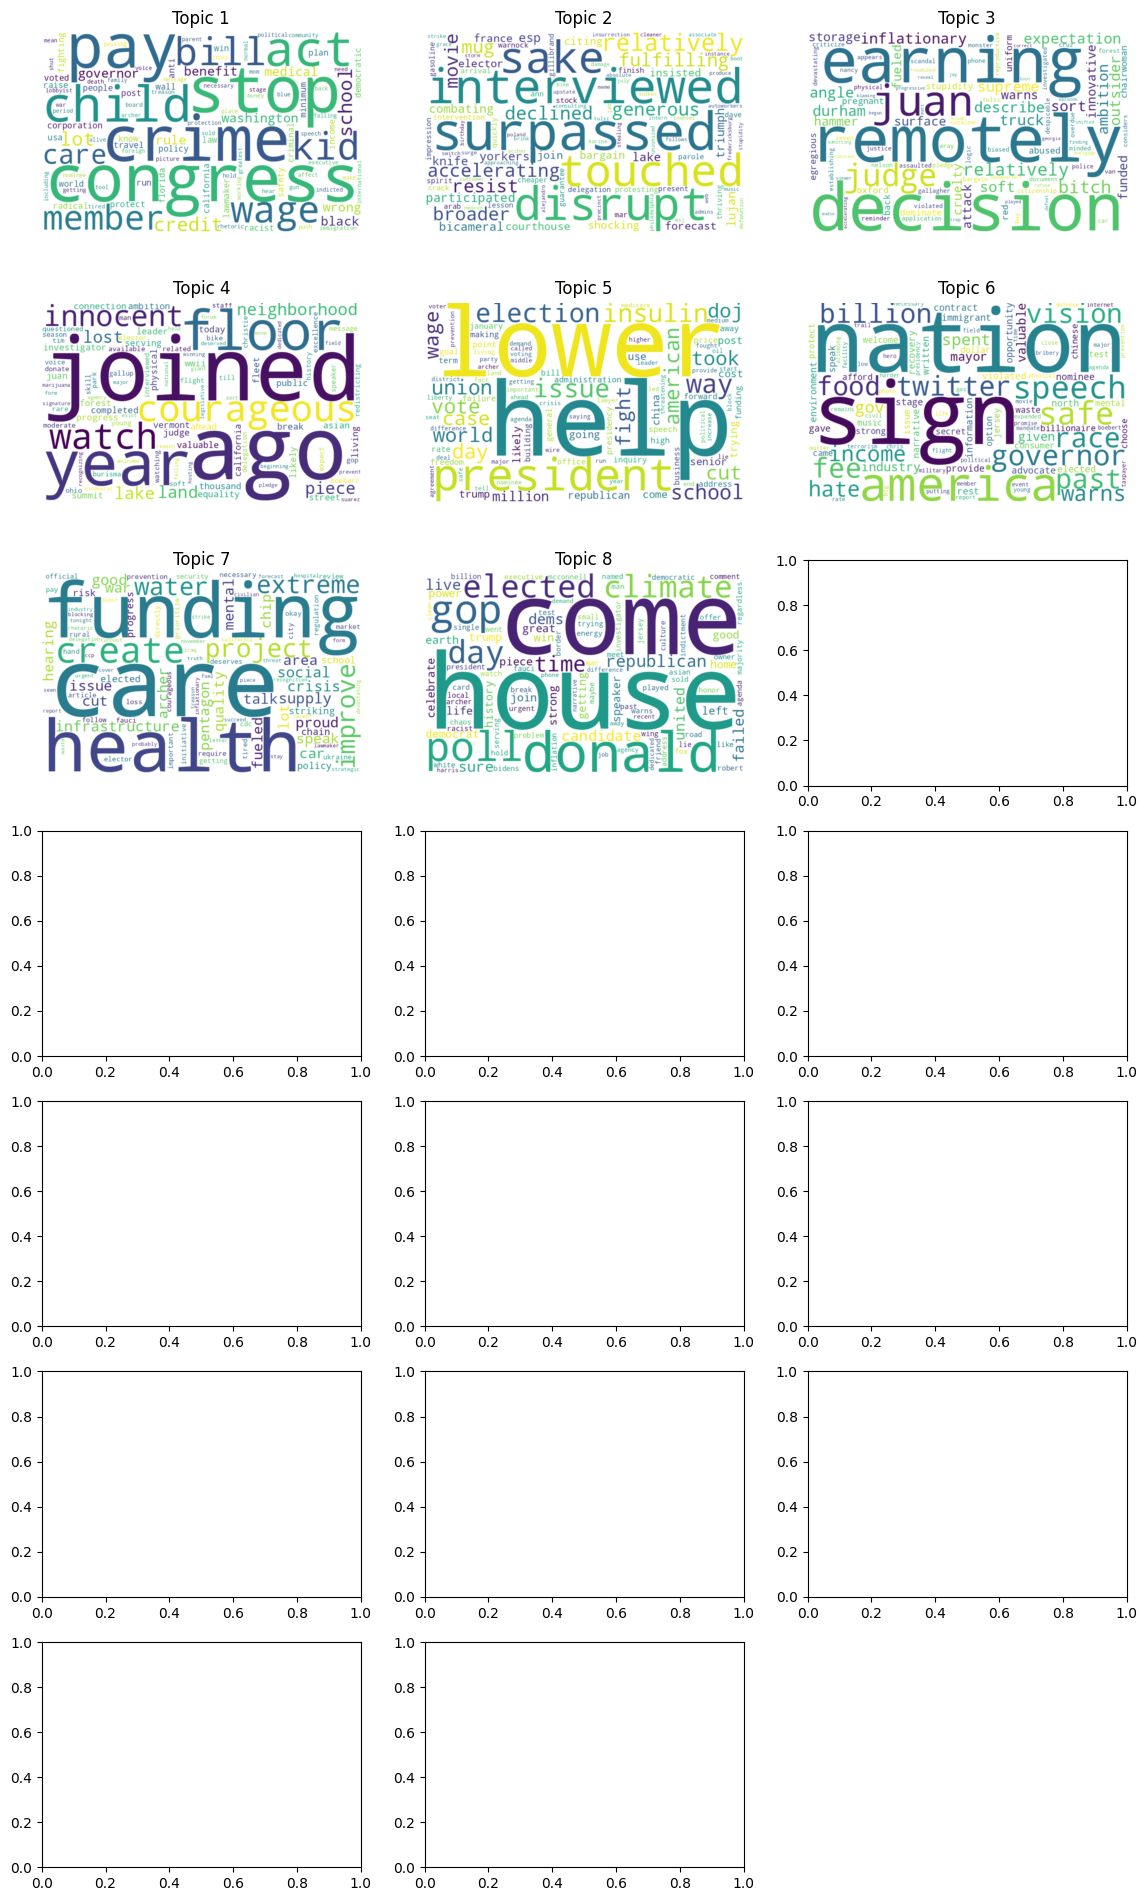

In [23]:
def plot_word_cloud(b, ax, v, n):
    sorted_, indices = torch.sort(b, descending=True)
    df = pd.DataFrame(indices[:100].numpy(), columns=['index'])
    words = pd.merge(df, vocab[['index', 'word']],
                     how='left', on='index')['word'].values.tolist()
    sizes = (sorted_[:100] * 1000).int().numpy().tolist()
    freqs = {words[i]: sizes[i] for i in range(len(words))}
    wc = WordCloud(background_color="white", width=800, height=500)
    wc = wc.generate_from_frequencies(freqs)
    ax.set_title('Topic %d' % (n + 1))
    ax.imshow(wc, interpolation='bilinear')
    ax.axis("off")

if not smoke_test:
    

    beta = prodLDA1.beta() #ACCESSING THE TOPICS from the model
    fig, axs = plt.subplots(7, 3, figsize=(14, 24))
    for n in range(beta.shape[0]):
        i, j = divmod(n, 3)
        plot_word_cloud(beta[n], axs[i, j], vocab, n)
    axs[-1, -1].axis('off');

    plt.show()